In [109]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md


from cvx.covariance.trading_model import *
from cvx.covariance.utils import *
from cvx.covariance.ewma import ewma_cov, iterated_ewma
from cvx.covariance.covariance_combination import CovarianceCombination
sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [79]:
returns = pd.read_csv('../data/SP500_top25_adjusted.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# Covariance predictors

In [114]:
# Rolling window 
rw = rolling_window(returns, 250) 

In [115]:
# EWMA
ewma_125 = dict(ewma_cov(returns, halflife=125))

In [116]:
# IEWMA  
iewma_63_125 = iterated_ewma(returns, vola_halflife=63, cov_halflife=125) 

In [159]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r due to numerical issues 

mgarch_cond_cov = pd.read_csv("../mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[250:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

In [135]:
# CM-IEWMA
pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]
Sigmas = {f"{pair[0]}-{pair[1]}": iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63) for pair in pairs}
Sigmas["10-21"] = regularize_covariance(Sigmas["10-21"], lamda=0.05)

results = list(CovarianceCombination(Sigmas=Sigmas, returns=returns).solve_window(window=10, verbose=True))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

100%|██████████| 3138/3138 [00:48<00:00, 64.67it/s]


In [158]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    prescient[t] = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)

# Define end and start dates for backtests

In [160]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [162]:
names = ["RW-250", "EWMA-125", "IEWMA-63-125", "MGARCH", "CM-IEWMA", "PRESCIENT"]

predictors_temp = [rw, ewma_125, iewma_63_125, mgarch, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

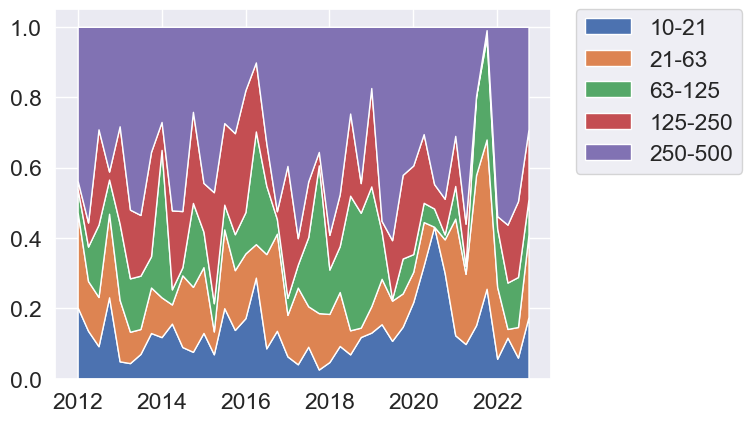

In [153]:
quarterly_weights  = pd.DataFrame(weights).T.resample("Q").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=["10-21", "21-63", "63-125", "125-250", "250-500"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

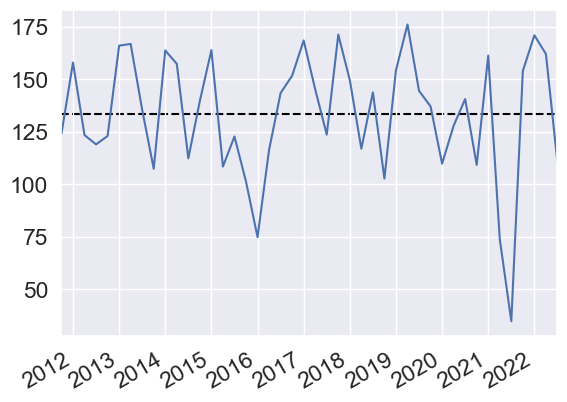

In [155]:
halflifes_vola = np.array([10, 21, 63, 125, 250])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# Log likelihoods

In [165]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

Computing RW-250 log-likelihood...
Computing EWMA-125 log-likelihood...
Computing IEWMA-63-125 log-likelihood...
Computing MGARCH log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing PRESCIENT log-likelihood...


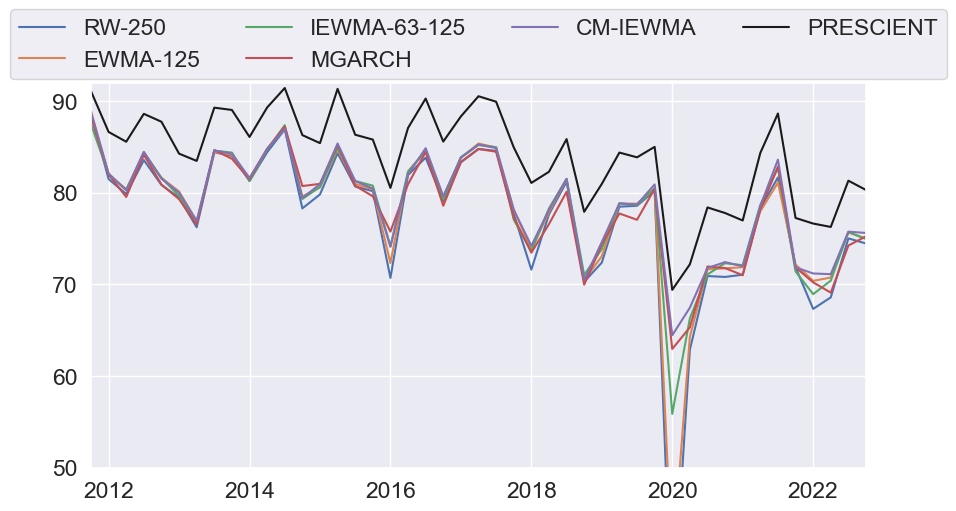

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

# Regrets

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

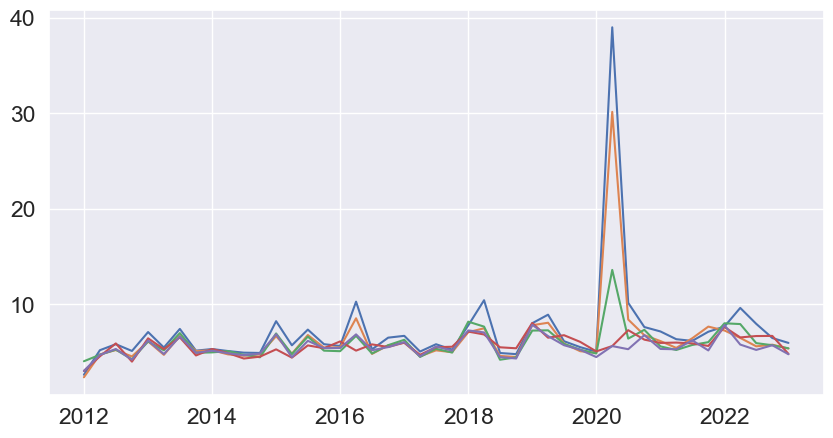

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
all_regrets = []
for i, predictor in enumerate(predictors[:-1]):
    regret =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - predictor.log_likelihoods.resample("Q").mean()
            
    plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret)
    all_regrets.append(regret.values.flatten())

# plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=labels, scatterpoints=1, markerscale=5);
# plt.ylim(5,75);


### Compare CM-IEWMA with MGARCH

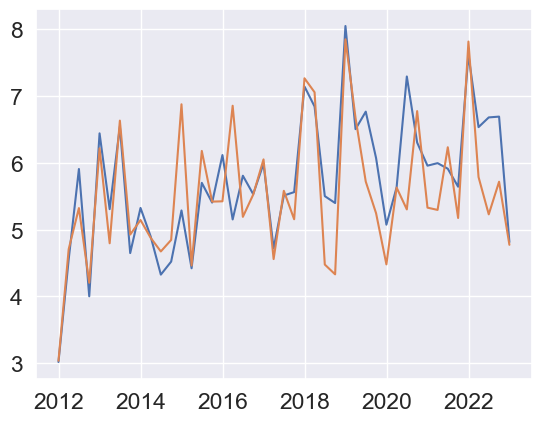

In [45]:
# Regret or W-IT-EWMA and MGARCH
regret_mgarch =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - mgarch.log_likelihoods.resample("Q").mean()

plt.plot(mgarch.log_likelihoods.resample("Q").mean().index, regret_mgarch, label=mgarch.name)

regret_cm_iewma =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - cm_iewma.log_likelihoods.resample("Q").mean()

plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret_cm_iewma, label=cm_iewma.name)
# plt.legend();

In [46]:
cm_iewma_advantage = ((regret_cm_iewma.values - regret_mgarch.values)<0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 56% of the time


### Regret CDF plots

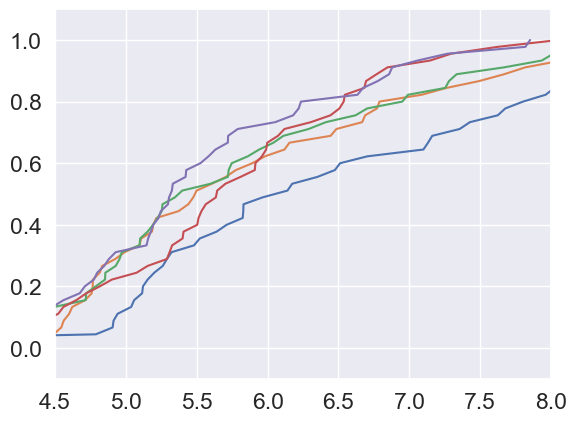

In [47]:
plot_ecdf(all_regrets, labels=labels[:-1])
plt.xlim(4.5,8)
plt.ylim(-0.1,1.1)
# put label to right of plot
# plt.legend(bbox_to_anchor=(1.27, 1.02), loc='upper center', ncol=1, labels=labels[:-1]);
# remove legend
plt.legend().remove()

### Regret metrics

In [29]:
### Metrics
print("(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)")

for i, predictor in enumerate(predictors):
    print("\n", labels[i])

    # regret =  predictors[last].log_likelihoods.resample("Q").mean() -\
    #     predictor.log_likelihoods.resample("Q").mean()
    # regret = regret.values
    
    if i < prescient_ind:
        regret = all_regrets[i]
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1), np.quantile(regret, 0.99).round(1),\
            np.quantile(regret, 0.95).round(1), np.quantile(regret, 0.9).round(1))

        print(metrics)
    else:
        print((0.0, 0.0, 0.0, 0.0, 0.0, 0.0))

(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)

 RW-250
(7.2, 5.1, 39.0, 26.4, 10.3, 9.3)

 EWMA-125
(6.3, 3.8, 30.1, 20.6, 8.3, 7.8)

 IEWMA-63-125
(5.9, 1.6, 13.6, 11.2, 8.0, 7.5)

 MGARCH
(5.7, 1.0, 8.1, 7.9, 7.3, 6.8)

 CM-IEWMA
(5.5, 1.0, 7.9, 7.8, 7.2, 6.9)

 PRESCIENT
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


In [64]:
temp = cm_iewma.log_likelihoods.resample("M").mean().values

# get percentiles of temp
print("\n", "CM-IEWMA")
print((np.mean(temp).round(1), np.std(temp).round(1), np.max(temp).round(1), np.quantile(temp, 0.99).round(1),\
    np.quantile(temp, 0.95).round(1), np.quantile(temp, 0.9).round(1)))


 CM-IEWMA
(78.7, 6.8, 90.8, 90.2, 87.6, 86.3)


In [65]:
np.quantile(temp,1)

90.82509011102069

In [60]:
np.quantile(temp,0.99)

87.94209334438034

In [66]:
temp.shape

(133, 1)

In [59]:
np.max(temp)

88.6889984670434

# Portfolio optimization

In [23]:
# Risk-free rate for backtest period; for cash allocation
rf = rf_rate.loc[start_date:end_date]

# Portfolio constraints
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}

# Volatility target
sigma_tar = 0.1

### Equally weighted

In [24]:
from cvx.covariance.trading_model import *
adjust_factor = 1

traders_eq_w = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.ws = np.ones(trader.R.shape) / trader.n
    trader.portfolio_type = "eq_weighted"
    trader.adjust_factor = adjust_factor
    traders_eq_w.append(trader)

100%|██████████| 6/6 [00:00<00:00, 29.73it/s]


In [25]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_eq_w):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 6.80%
Annual risk: 10.87%
Sharpe ratio: 0.625
Maximum drawdown: 22.65%

EWMA-125
Mean annual return: 6.34%
Annual risk: 10.01%
Sharpe ratio: 0.633
Maximum drawdown: 21.06%

IEWMA-63-125
Mean annual return: 6.66%
Annual risk: 10.05%
Sharpe ratio: 0.662
Maximum drawdown: 19.94%

MGARCH
Mean annual return: 7.13%
Annual risk: 9.42%
Sharpe ratio: 0.757
Maximum drawdown: 15.17%

CM-IEWMA
Mean annual return: 6.43%
Annual risk: 9.81%
Sharpe ratio: 0.655
Maximum drawdown: 18.99%

PRESCIENT
Mean annual return: 12.80%
Annual risk: 9.98%
Sharpe ratio: 1.28
Maximum drawdown: 9.85%


In [32]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_eq_w):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 6.80%
Annual risk: 10.87%
Sharpe ratio: 0.625
Maximum drawdown: 22.65%

EWMA-125
Mean annual return: 6.34%
Annual risk: 10.01%
Sharpe ratio: 0.633
Maximum drawdown: 21.06%

IEWMA-63-125
Mean annual return: 6.66%
Annual risk: 10.05%
Sharpe ratio: 0.662
Maximum drawdown: 19.94%

MGARCH
Mean annual return: 7.13%
Annual risk: 9.42%
Sharpe ratio: 0.757
Maximum drawdown: 15.17%

CM-IEWMA
Mean annual return: 6.77%
Annual risk: 9.68%
Sharpe ratio: 0.699
Maximum drawdown: 16.95%

PRESCIENT
Mean annual return: 12.80%
Annual risk: 9.98%
Sharpe ratio: 1.28
Maximum drawdown: 9.85%


In [39]:
def annaual_risk(rets):
    r_squared = rets**2
    return r_squared.resample("Y").mean()**0.5 * np.sqrt(252)

def annaual_SR(rets):
    r_squared = rets**2
    sigma = r_squared.resample("Y").mean()**0.5 * np.sqrt(252)
    mu = rets.resample("Y").mean() * 252
    return mu/sigma


### Minimum risk

In [26]:
from cvx.covariance.trading_model import *

adjust_factor = 1

C_speedup = False # True if solving using CVXPYgen
traders_min_risk = []

for i in trange(len(predictors)):
     predictor = predictors[i]
     R = predictor.R.loc[start_date:end_date]
     Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
     Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}

     trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
     trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
          C_speedup=C_speedup)
     traders_min_risk.append(trader)


  0%|          | 0/6 [00:00<?, ?it/s]

Adding additional constraints


 17%|█▋        | 1/6 [00:15<01:17, 15.45s/it]

Adding additional constraints


 33%|███▎      | 2/6 [00:32<01:06, 16.68s/it]

Adding additional constraints


 50%|█████     | 3/6 [00:49<00:49, 16.49s/it]

Adding additional constraints


 67%|██████▋   | 4/6 [01:06<00:33, 16.82s/it]

Adding additional constraints


 83%|████████▎ | 5/6 [01:23<00:16, 16.83s/it]

Adding additional constraints


100%|██████████| 6/6 [01:44<00:00, 17.46s/it]


In [28]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_min_risk):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 9.65%
Annual risk: 12.28%
Sharpe ratio: 0.786
Maximum drawdown: 23.83%

EWMA-125
Mean annual return: 8.89%
Annual risk: 11.09%
Sharpe ratio: 0.801
Maximum drawdown: 20.44%

IEWMA-63-125
Mean annual return: 9.64%
Annual risk: 11.31%
Sharpe ratio: 0.853
Maximum drawdown: 19.24%

MGARCH
Mean annual return: 11.24%
Annual risk: 12.32%
Sharpe ratio: 0.912
Maximum drawdown: 17.77%

CM-IEWMA
Mean annual return: 8.32%
Annual risk: 10.97%
Sharpe ratio: 0.758
Maximum drawdown: 17.19%

PRESCIENT
Mean annual return: 20.99%
Annual risk: 10.05%
Sharpe ratio: 2.09
Maximum drawdown: 11.38%


In [34]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_min_risk):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 9.65%
Annual risk: 12.28%
Sharpe ratio: 0.786
Maximum drawdown: 23.83%

EWMA-125
Mean annual return: 8.89%
Annual risk: 11.09%
Sharpe ratio: 0.801
Maximum drawdown: 20.44%

IEWMA-63-125
Mean annual return: 9.64%
Annual risk: 11.31%
Sharpe ratio: 0.853
Maximum drawdown: 19.24%

MGARCH
Mean annual return: 11.24%
Annual risk: 12.32%
Sharpe ratio: 0.912
Maximum drawdown: 17.77%

CM-IEWMA
Mean annual return: 9.29%
Annual risk: 11.01%
Sharpe ratio: 0.844
Maximum drawdown: 15.37%

PRESCIENT
Mean annual return: 20.99%
Annual risk: 10.05%
Sharpe ratio: 2.09
Maximum drawdown: 11.38%


### Maximum diversification 

In [35]:
from cvx.covariance.trading_model import *

# Only additonal_cons["upper_bound"] relevant for max diverse

adjust_factor = 1

traders_max_diverse = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
         portfolio_type="max_diverse")
    traders_max_diverse.append(trader)

100%|██████████| 6/6 [00:55<00:00,  9.17s/it]


In [36]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_max_diverse):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 8.63%
Annual risk: 11.45%
Sharpe ratio: 0.754
Maximum drawdown: 21.49%

EWMA-125
Mean annual return: 7.86%
Annual risk: 10.45%
Sharpe ratio: 0.753
Maximum drawdown: 20.93%

IEWMA-63-125
Mean annual return: 8.15%
Annual risk: 10.35%
Sharpe ratio: 0.787
Maximum drawdown: 19.89%

MGARCH
Mean annual return: 9.93%
Annual risk: 9.76%
Sharpe ratio: 1.02
Maximum drawdown: 15.11%

CM-IEWMA
Mean annual return: 8.90%
Annual risk: 10.01%
Sharpe ratio: 0.889
Maximum drawdown: 16.18%

PRESCIENT
Mean annual return: 16.53%
Annual risk: 10.01%
Sharpe ratio: 1.65
Maximum drawdown: 10.82%


### Risk parity 

In [37]:
from cvx.covariance.trading_model import *
adjust_factor = 1
    
traders_risk_par = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, portfolio_type="risk_parity")
    traders_risk_par.append(trader)

100%|██████████| 6/6 [01:47<00:00, 17.84s/it]


In [38]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_risk_par):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 7.39%
Annual risk: 11.11%
Sharpe ratio: 0.665
Maximum drawdown: 22.41%

EWMA-125
Mean annual return: 6.74%
Annual risk: 10.11%
Sharpe ratio: 0.667
Maximum drawdown: 20.67%

IEWMA-63-125
Mean annual return: 7.20%
Annual risk: 10.16%
Sharpe ratio: 0.708
Maximum drawdown: 19.61%

MGARCH
Mean annual return: 7.86%
Annual risk: 9.67%
Sharpe ratio: 0.812
Maximum drawdown: 15.49%

CM-IEWMA
Mean annual return: 7.35%
Annual risk: 9.75%
Sharpe ratio: 0.754
Maximum drawdown: 16.35%

PRESCIENT
Mean annual return: 15.11%
Annual risk: 9.98%
Sharpe ratio: 1.51
Maximum drawdown: 9.74%


### Maximum Sharp ratio

In [39]:
from cvx.covariance.trading_model import *
    
# EWMA returns
r_ewma = get_ewmas(data.values, T_half=63)
r_hat_ewma = pd.DataFrame(r_ewma[:-1], index=data.index[1:],\
     columns=data.columns)
r_hat_ewma = r_hat_ewma.loc[start_date:end_date] 

# previous day's returns
# r_hats = pd.DataFrame(data.iloc[:-1].values, index=data.index[1:],\
#      columns=data.columns)
# r_hats = r_hats.loc[start_date:end_date]

traders_max_sharpe = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats,\
    r_hats=r_hat_ewma)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
        portfolio_type="mean_variance", sigma_des=sigma_tar)
    traders_max_sharpe.append(trader)

100%|██████████| 6/6 [02:22<00:00, 23.67s/it]


In [40]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_max_sharpe):
    print("\n"+labels[i])
    trader.get_metrics(diluted_with_cash=False, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 2.62%
Annual risk: 12.07%
Sharpe ratio: 0.217
Maximum drawdown: 28.16%

EWMA-125
Mean annual return: 2.61%
Annual risk: 11.21%
Sharpe ratio: 0.233
Maximum drawdown: 24.68%

IEWMA-63-125
Mean annual return: 3.17%
Annual risk: 10.94%
Sharpe ratio: 0.289
Maximum drawdown: 22.80%

MGARCH
Mean annual return: 2.31%
Annual risk: 11.14%
Sharpe ratio: 0.207
Maximum drawdown: 20.96%

CM-IEWMA
Mean annual return: 3.12%
Annual risk: 10.94%
Sharpe ratio: 0.286
Maximum drawdown: 19.97%

PRESCIENT
Mean annual return: 9.67%
Annual risk: 9.73%
Sharpe ratio: 0.994
Maximum drawdown: 14.13%


In [41]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_max_sharpe):
    print("\n"+labels[i])
    trader.get_metrics(diluted_with_cash=False, rf=rf,\
        excess=excess)


RW-250
Mean annual return: 2.62%
Annual risk: 12.07%
Sharpe ratio: 0.217
Maximum drawdown: 28.16%

EWMA-125
Mean annual return: 2.61%
Annual risk: 11.21%
Sharpe ratio: 0.233
Maximum drawdown: 24.68%

IEWMA-63-125
Mean annual return: 3.17%
Annual risk: 10.94%
Sharpe ratio: 0.289
Maximum drawdown: 22.80%

MGARCH
Mean annual return: 2.31%
Annual risk: 11.14%
Sharpe ratio: 0.207
Maximum drawdown: 20.96%

CM-IEWMA
Mean annual return: 3.12%
Annual risk: 10.94%
Sharpe ratio: 0.286
Maximum drawdown: 19.97%

PRESCIENT
Mean annual return: 9.67%
Annual risk: 9.73%
Sharpe ratio: 0.994
Maximum drawdown: 14.13%
